# scikit-learn Pneumonia detection

This notebook's purpose is to find the optimal model to detect pneunomia

In [17]:
import os
import cv2 #open cv
import numpy as np
import matplotlib.pyplot as plt

## Load data

Declaration of the function that transform the data to a standardised format.

This allow for an easier comparison and by lowering the resolution allow for faster training

In [18]:
def load_dataset(dataset_path):
    data = []
    labels = []
    label_id = 0
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        if os.path.isdir(folder_path):
            for img_path in os.listdir(folder_path):
                if not (img_path.endswith(".jpeg") or img_path.endswith(".jpg")) :
                    print("Skipping file: ", img_path)
                    continue
                img = cv2.imread(os.path.join(folder_path, img_path), cv2.IMREAD_GRAYSCALE)
                #print(img, os.path.join(folder_path, img_path))
                if img is None:
                    print("Error: Could not read the image")
                else:
                    img_resized = cv2.resize(img, (32, 32))
                    img_flattened = img_resized.flatten()
                    
                    data.append(img_flattened)
                    labels.append(label_id)
            label_id =1

    return np.array(data), np.array(labels)

dataset_test_path = "../data/chest_Xray/test"
dataset_train_path = "../data/chest_Xray/train"
dataset_train_aug_path = "../data/chest_Xray/train_augmented"


As the data has already been filtered and sorted in sub folder, there is no need to train_test_split() the data.

We fed the variables with the regular data and an augmented one, that contains the same data but slightly altered in it's axis, rotations, zoom etc...

In [19]:
# load data
X_train, y_train = load_dataset(dataset_train_path)
X_train_aug, y_train_aug = load_dataset(dataset_train_aug_path)
X_test, y_test = load_dataset(dataset_test_path)


Skipping file:  .DS_Store
Skipping file:  .DS_Store


Here we can see sample from the regular and augmented date, each with normal healthy body and a pneunomia infected body.

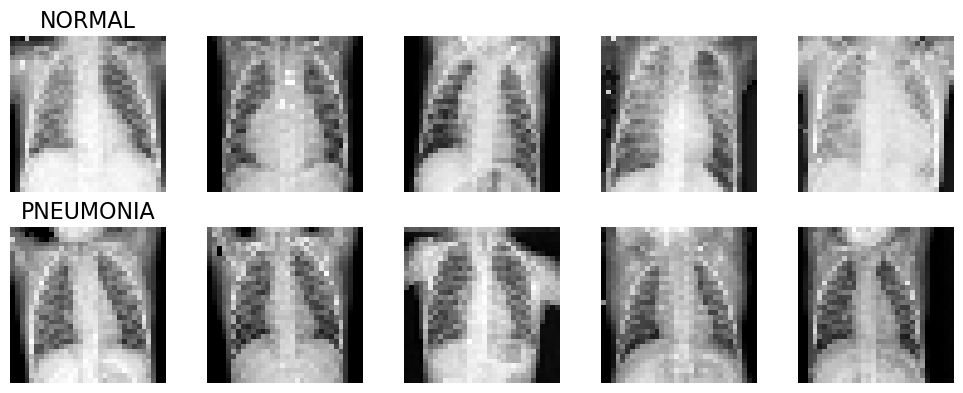

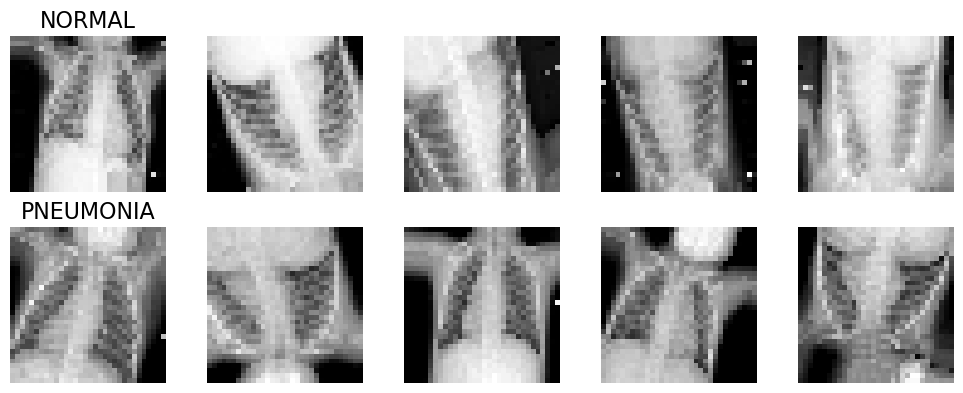

In [20]:
def visualize_data(data, labels, label_names, num_images_per_class=10):
    num_classes = len(set(labels))
    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(num_images_per_class * 2, num_classes * 2))
    
    for label_id in range(num_classes):
        label_indices = np.where(labels == label_id)[0]
        sample_indices = np.random.choice(label_indices, size=num_images_per_class, replace=False)

        for i, img_index in enumerate(sample_indices):
            img = data[img_index].reshape(32, 32)
            axes[label_id, i].imshow(img, cmap='gray')
            axes[label_id, i].axis('off')

            if i == 0:
                axes[label_id, i].set_title(label_names[label_id], fontsize=16)

    plt.tight_layout()
    plt.show()

label_names = ["NORMAL", "PNEUMONIA"]
visualize_data(X_train, y_train, label_names, num_images_per_class=5)
visualize_data(X_train_aug, y_train_aug, label_names, num_images_per_class=5)

In [21]:
X_train = np.concatenate((X_train, X_train_aug))
y_train = np.concatenate((y_train, y_train_aug))

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Linear SVC
Separate the data into 2 or more classes, maximise the difference between classes. the larger the difference the more precise the model

![cnn](./images/sphx_glr_plot_iris_svc_001.png)

In [22]:
from sklearn.svm import LinearSVC
# build the model
svc = LinearSVC(max_iter=1000, random_state=0)
# train the model
svc.fit(X_train,y_train)

/Users/judevl/miniconda3/envs/venv-mac/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=0)

## Evaluate the model

Evaluation Metrics: These are quantitative measures that help you assess your model's performance on the test data. Some popular metrics for classification tasks include:

- Accuracy: The proportion of correctly classified instances out of the total instances.
- Precision: The proportion of true positive instances among the instances predicted as positive.
- Recall (Sensitivity): The proportion of true positive instances among the actual positive instances.
- F1-score: The harmonic mean of precision and recall, providing a balanced measure of both metrics.
- Confusion Matrix: A table that shows the distribution of predicted and actual class labels, helping you identify where the model is making mistakes.

Visualization: Visualizing the model's predictions can help you better understand its performance. You can create plots and charts to display the results, such as:

- Confusion Matrix:
- Confusion Matrix Heatmap: A visual representation of the confusion matrix that highlights the model's mistakes.
- Classification Report: A table that shows precision, recall, and F1-score for each class.
- ROC Curve and AUC: A plot that shows the true positive rate against the false positive rate for different decision thresholds. The area under the curve (AUC) is a measure of the model's performance.

In [23]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score,roc_curve,auc, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns



def crossValidationMetrics(model ,X,y):

    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1_score': make_scorer(f1_score, average='weighted')
    }

    # Assuming 'model' is your classifier (e.g., LinearSVC, RandomForestClassifier, etc.)
    # Utiliser la fonction cross_val_score pour évaluer la qualité des prédictions
    cv_scores = cross_validate(model, X, y, cv=5, scoring=scoring)

    print("*********************")
    print("   Qualité de la prédiction   ")
    print("*********************")
    # Afficher les scores de validation croisée
    for metric_name, scores_array in cv_scores.items():
        print(f"{metric_name.capitalize()}: {scores_array.mean():.2f} (+/- {scores_array.std() * 2:.2f})")


def evaluateModel(model, X_test, y_test):

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Compute evaluation metrics on the test data
    accuracy_scores = accuracy_score(y_test, y_pred)
    precision_scores = precision_score(y_test, y_pred, average='weighted')
    recall_scores = recall_score(y_test, y_pred, average='weighted')
    f1_scores = f1_score(y_test, y_pred, average='weighted')
    
    print("*********************")
    print("   Evaluation du modèle   ")
    print("*********************")

    # Print evaluation metrics
    print("Accuracy on test data: %0.2f" % accuracy_scores)
    print("Precision on test data: %0.2f" % precision_scores)
    print("Recall on test data: %0.2f" % recall_scores)
    print("F1-score on test data: %0.2f" % f1_scores)

    # Compute and display the confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    print("Confusion matrix on test data:")
    print(conf_mat)

    # Display the classification report
    class_rep = classification_report(y_test, y_pred)
    print("Classification report on test data:")
    print(class_rep)

    # Display the confusion matrix heatmap
    showConfusionMatrixHeatMap(conf_mat)
    # Display the ROC curve and AUC
    showRocCurveAuc(y_test, y_pred)


def showConfusionMatrixHeatMap(cm):
    # Confusion Matrix Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix Heatmap")
    plt.show()

def showRocCurveAuc(y_test, y_pred):

    # ROC Curve and AUC (for binary classification)
    if len(label_names) == 2:
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')

*********************
   Evaluation du modèle   
*********************
Accuracy on test data: 0.77
Precision on test data: 0.78
Recall on test data: 0.77
F1-score on test data: 0.75
Confusion matrix on test data:
[[376  22]
 [128 114]]
Classification report on test data:
              precision    recall  f1-score   support

           0       0.75      0.94      0.83       398
           1       0.84      0.47      0.60       242

    accuracy                           0.77       640
   macro avg       0.79      0.71      0.72       640
weighted avg       0.78      0.77      0.75       640



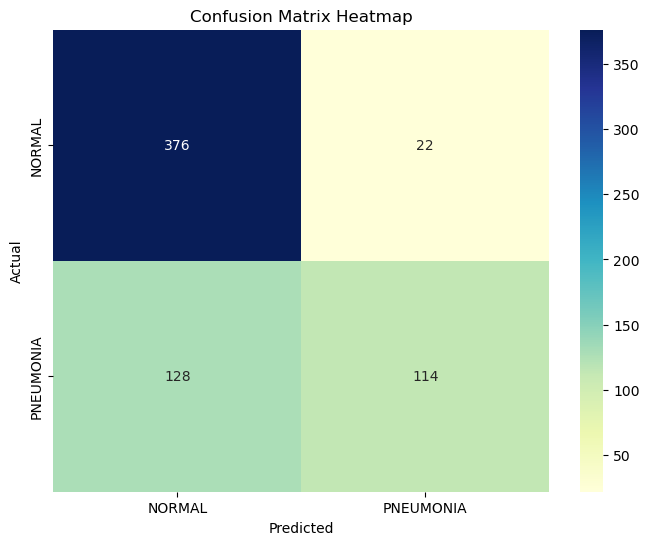

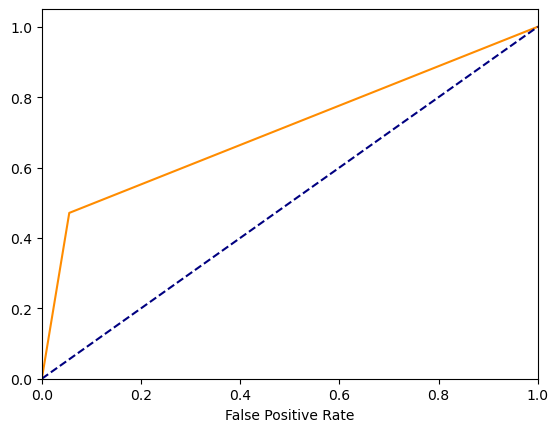

In [24]:
evaluateModel(svc,X_test,y_test)

### Optimize the model

*********************
   Evaluation du modèle   
*********************
Accuracy on test data: 0.76
Precision on test data: 0.79
Recall on test data: 0.76
F1-score on test data: 0.74
Confusion matrix on test data:
[[385  13]
 [139 103]]
Classification report on test data:
              precision    recall  f1-score   support

           0       0.73      0.97      0.84       398
           1       0.89      0.43      0.58       242

    accuracy                           0.76       640
   macro avg       0.81      0.70      0.71       640
weighted avg       0.79      0.76      0.74       640



/Users/judevl/miniconda3/envs/venv-mac/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


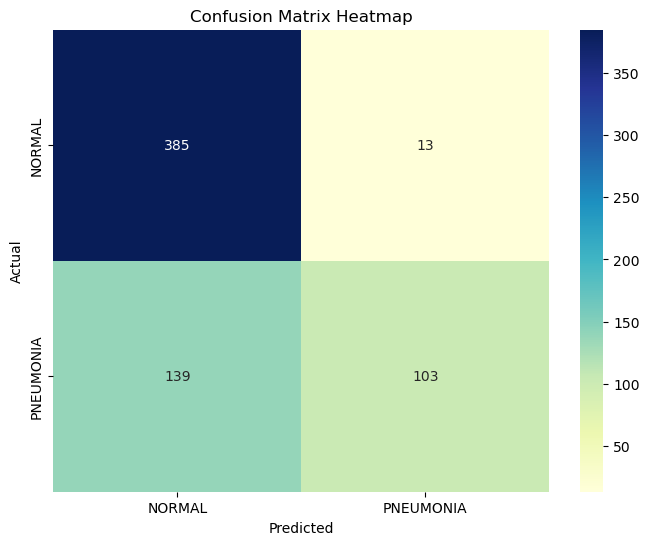

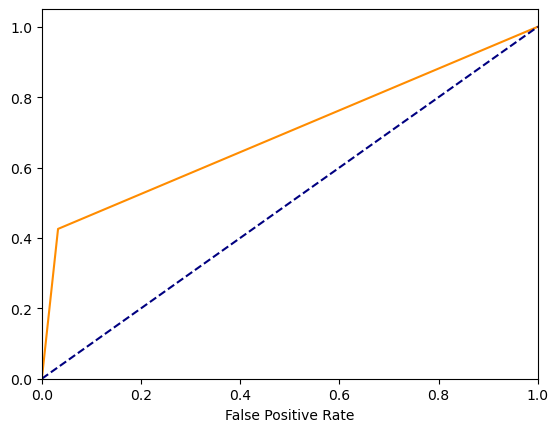

In [25]:
# build the model
svc = LinearSVC(max_iter=20000, random_state=0)
# train the model
svc.fit(X_train,y_train)
# Evaluate
evaluateModel(svc,X_test,y_test)

## Export the model
pickle, utility of pickle...

In [26]:
import pickle
import os



def saveModel(model,model_name,augmented_data=False):
   
    # obtenir le répertoire de travail actuel
    cwd = os.getcwd()

    if augmented_data == True:
        data_path = "augmented"
    else:
        data_path = "original"

    # construire le chemin relatif pour le dossier de stockage des modèles
    model_folder_path = os.path.join(cwd, "sk_models")

    # créer le dossier si nécessaire
    if not os.path.exists(model_folder_path):
        os.mkdir(model_folder_path)

    model_folder_path = os.path.join(model_folder_path, data_path)

    # créer le dossier si nécessaire
    if not os.path.exists(model_folder_path):
        os.mkdir(model_folder_path)

    # construire le chemin complet pour le modèle
    model_path = os.path.join(model_folder_path, model_name + ".pkl")

    # enregistrer le modèle
    with open(model_path, 'wb') as file:
        pickle.dump(model, file)

def loadModel(model_name,augmented_data=False):
     # obtenir le répertoire de travail actuel
    cwd = os.getcwd()

    if augmented_data == True:
        data_path = "augmented"
    else:
        data_path = "original"

    # construire le chemin relatif pour le dossier de stockage des modèles
    model_folder_path = os.path.join(cwd, "sk_models")

    model_folder_path = os.path.join(model_folder_path, data_path)

    # construire le chemin complet pour le modèle
    model_path = os.path.join(model_folder_path, model_name + ".pkl")

    # lire le modèle
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
    return model

In [27]:
# save the svc model and recuperer
# predire une donnée
# saveModel(neigh,"kneighbors")
# neighLoadModel=loadModel("kneighbors")

*********************
   Evaluation du modèle   
*********************
Accuracy on test data: 0.71
Precision on test data: 0.80
Recall on test data: 0.71
F1-score on test data: 0.65
Confusion matrix on test data:
[[397   1]
 [185  57]]
Classification report on test data:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       398
           1       0.98      0.24      0.38       242

    accuracy                           0.71       640
   macro avg       0.83      0.62      0.60       640
weighted avg       0.80      0.71      0.65       640



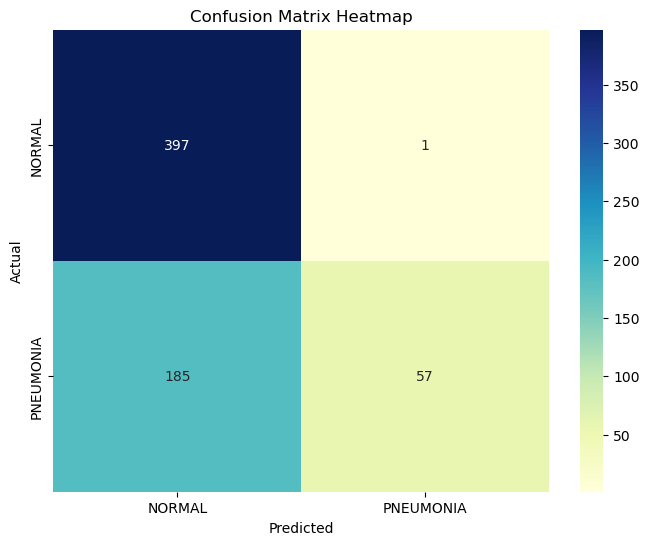

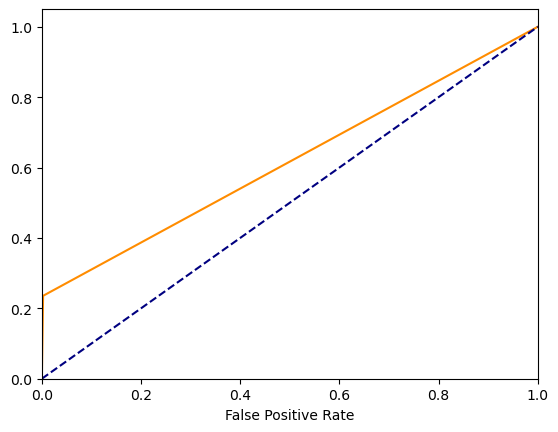

In [28]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=4, weights="uniform")
neigh.fit(X_train, y_train)
evaluateModel(neigh,X_test,y_test)

#### SVC model with Linear kernel

*********************
   Evaluation du modèle   
*********************
Accuracy on test data: 0.75
Precision on test data: 0.79
Recall on test data: 0.75
F1-score on test data: 0.72
Confusion matrix on test data:
[[386  12]
 [146  96]]
Classification report on test data:
              precision    recall  f1-score   support

           0       0.73      0.97      0.83       398
           1       0.89      0.40      0.55       242

    accuracy                           0.75       640
   macro avg       0.81      0.68      0.69       640
weighted avg       0.79      0.75      0.72       640



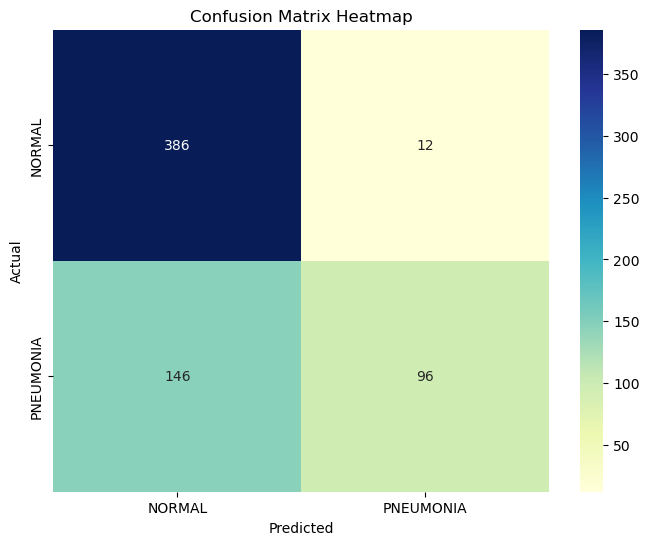

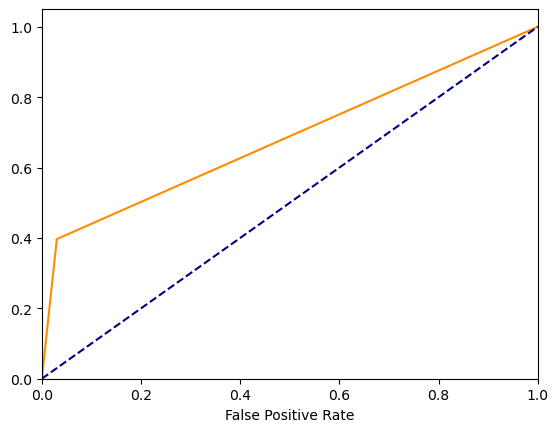

In [29]:
from sklearn.svm import SVC

svc = SVC(kernel="linear", random_state=0)
svc.fit(X_train, y_train)
evaluateModel(svc,X_test,y_test)


#### XGB model

XGBoost is a supervised machine learning algorithm based on boosting that combines multiple weak prediction models into a stronger model. It uses a set of features to create a decision tree at each iteration, placing more emphasis on previously mispredicted examples. The trees are sequentially added to improve predictions, using an optimized cost function. XGBoost is known for its ability to handle large datasets, robustness to missing values, and efficiency in terms of execution time

![cnn](./images/xgb.png)

Performance du modèle sur les données d'entraînement:
*********************
   Evaluation du modèle   
*********************
Accuracy on test data: 0.99
Precision on test data: 0.99
Recall on test data: 0.99
F1-score on test data: 0.99
Confusion matrix on test data:
[[7722   28]
 [ 104 2578]]
Classification report on test data:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7750
           1       0.99      0.96      0.98      2682

    accuracy                           0.99     10432
   macro avg       0.99      0.98      0.98     10432
weighted avg       0.99      0.99      0.99     10432



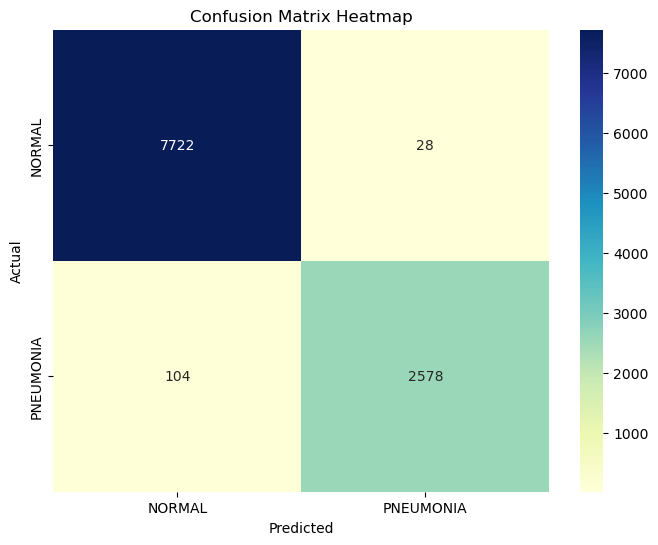

Performance du modèle sur les données de test:
*********************
   Evaluation du modèle   
*********************
Accuracy on test data: 0.77
Precision on test data: 0.81
Recall on test data: 0.77
F1-score on test data: 0.74
Confusion matrix on test data:
[[392   6]
 [141 101]]
Classification report on test data:
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       398
           1       0.94      0.42      0.58       242

    accuracy                           0.77       640
   macro avg       0.84      0.70      0.71       640
weighted avg       0.81      0.77      0.74       640



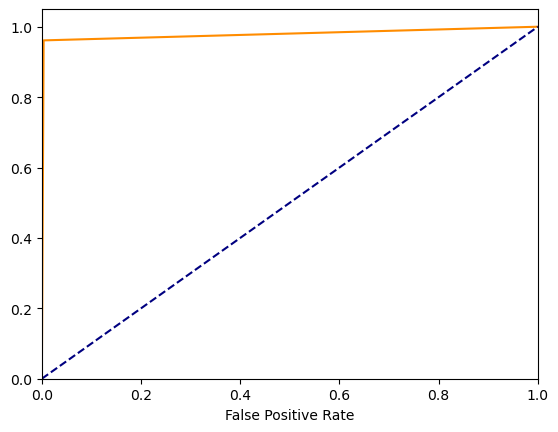

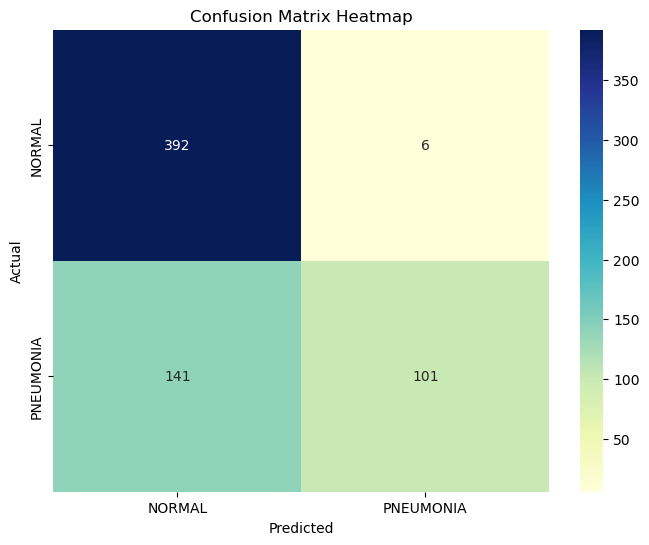

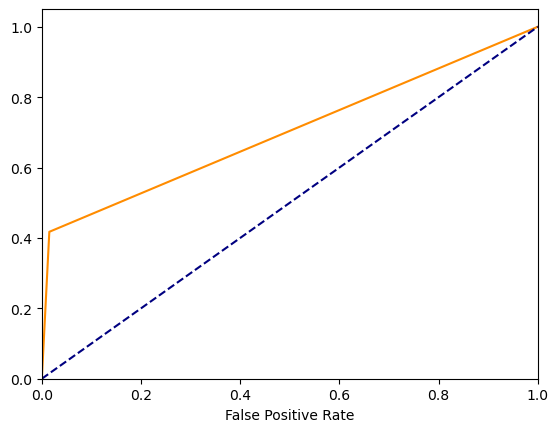

In [30]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Définir les hyperparamètres possibles
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.5, 0.75]
}

# Créer un objet GridSearchCV avec votre modèle et la grille de paramètres
grid_search = GridSearchCV(XGBClassifier(random_state=0, eval_metric='mlogloss'), param_grid, cv=5, n_jobs=-1)

# Exécuter la recherche par grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Obtenir les paramètres optimaux
best_params = grid_search.best_params_

# Entraîner le modèle avec les paramètres optimaux
xgb_classifier = XGBClassifier(**best_params, random_state=0, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train)

# Évaluer le modèle sur les données d'entraînement et de test
print('Performance du modèle sur les données d\'entraînement:')
evaluateModel(model=xgb_classifier, X_test=X_train, y_test=y_train)

print('Performance du modèle sur les données de test:')
evaluateModel(model=xgb_classifier, X_test=X_test, y_test=y_test)

## Optimize the model

Grid search is a method used to perform hyperparameter optimization, that is, it's a way to select the best of a family of hyperparameters, parametrized by a grid of parameters.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

rf = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Fitting 2 folds for each of 108 candidates, totalling 216 fits
Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Score:  0.863976226993865


*********************
   Evaluation du modèle   
*********************
Accuracy on test data: 0.82
Precision on test data: 0.85
Recall on test data: 0.82
F1-score on test data: 0.80
Confusion matrix on test data:
[[392   6]
 [112 130]]
Classification report on test data:
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       398
           1       0.96      0.54      0.69       242

    accuracy                           0.82       640
   macro avg       0.87      0.76      0.78       640
weighted avg       0.85      0.82      0.80       640



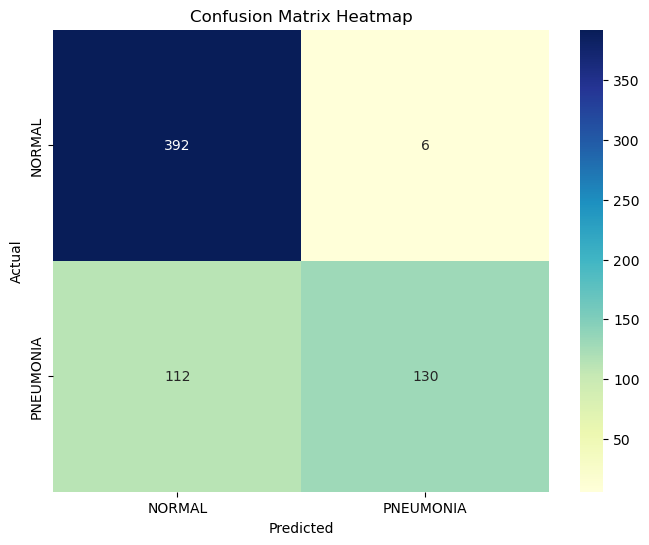

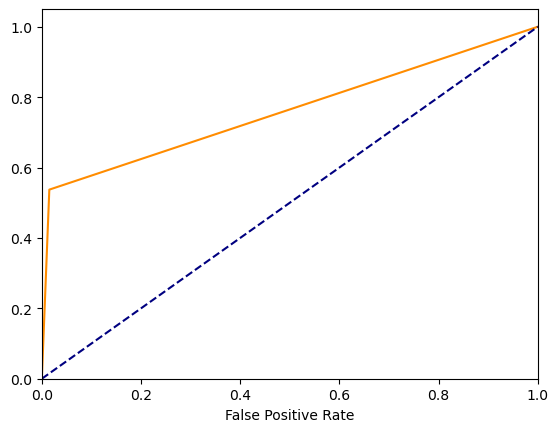

In [32]:
evaluateModel(grid_search.best_estimator_, X_test, y_test)

# best_rf = RandomForestClassifier(random_state=0, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=500)
# best_rf.fit(X_train, y_train)
# evaluateModel(best_rf, X_test, y_test)

## Catboost

The newest of the popular gradient boosting libraries, CatBoost (Categorical Boosting) was developed by the Russian tech company Yandex in mid-2017, following closely on the heels of LightGBM. Unfortunately, I have yet to see CatBoost consistently outperform its competitors (though with many categorical features it does tend to come out on top), nor match the speed of LightGBM, but that could definitely change with future updates. However, CatBoost was meant for cases such as categorical and text data, so please take the results of this article with a grain of salt when deciding which methods to try for your use-case.

*********************
   Evaluation du modèle   
*********************
Accuracy on test data: 0.76
Precision on test data: 0.81
Recall on test data: 0.76
F1-score on test data: 0.73
Confusion matrix on test data:
[[392   6]
 [146  96]]
Classification report on test data:
              precision    recall  f1-score   support

           0       0.73      0.98      0.84       398
           1       0.94      0.40      0.56       242

    accuracy                           0.76       640
   macro avg       0.83      0.69      0.70       640
weighted avg       0.81      0.76      0.73       640



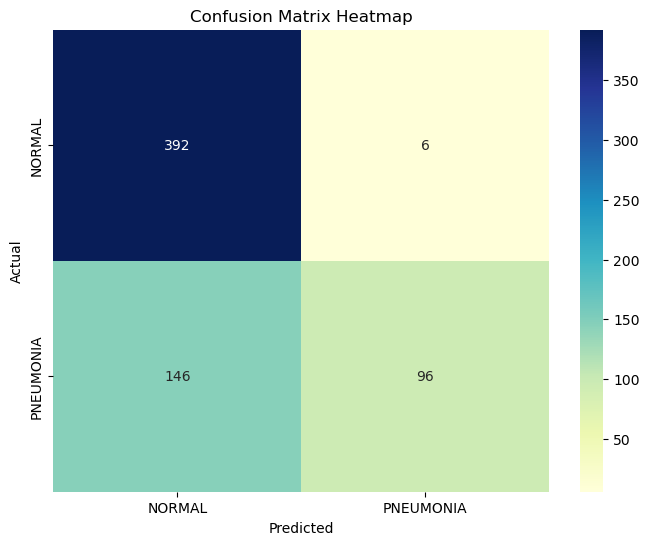

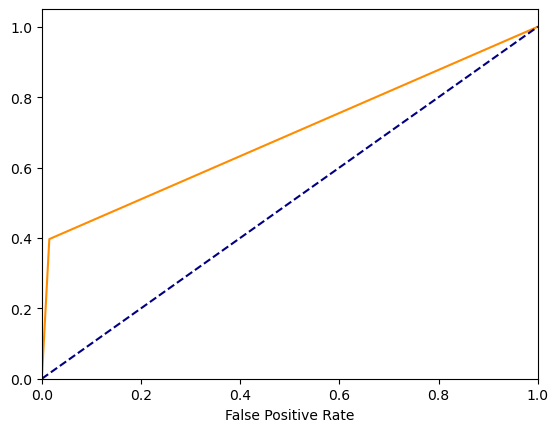

In [34]:


from catboost import CatBoostClassifier

cat_boost_cl = CatBoostClassifier(
    n_estimators=2000,
    max_leaves=31,
    subsample=0.67,
    verbose=0,
    thread_count=6,
    random_seed=0
)
cat_boost_cl.fit(X_train, y_train)
evaluateModel(cat_boost_cl, X_test, y_test)

##lightgbm

by microsoft 2017

In [35]:
import lightgbm as lgb

m_lgb = lgb.LGBMClassifier(
    n_estimators=2000,
    # feature_fraction=0.06,
    # bagging_fraction=0.67,
    # bagging_freq=1,
    verbose=0,
    n_jobs=6,
    random_state=0
)
m_lgb.fit(X_train, y_train)
#evaluateModel(m_lgb, X_test, y_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

LGBMClassifier(n_estimators=2000, n_jobs=6, random_state=0, verbose=0)

In [37]:
#https://towardsdatascience.com/boosting-showdown-scikit-learn-vs-xgboost-vs-lightgbm-vs-catboost-in-sentiment-classification-f7c7f46fd956

*********************
   Evaluation du modèle   
*********************
Accuracy on test data: 0.77
Precision on test data: 0.82
Recall on test data: 0.77
F1-score on test data: 0.74
Confusion matrix on test data:
[[392   6]
 [140 102]]
Classification report on test data:
              precision    recall  f1-score   support

           0       0.74      0.98      0.84       398
           1       0.94      0.42      0.58       242

    accuracy                           0.77       640
   macro avg       0.84      0.70      0.71       640
weighted avg       0.82      0.77      0.74       640



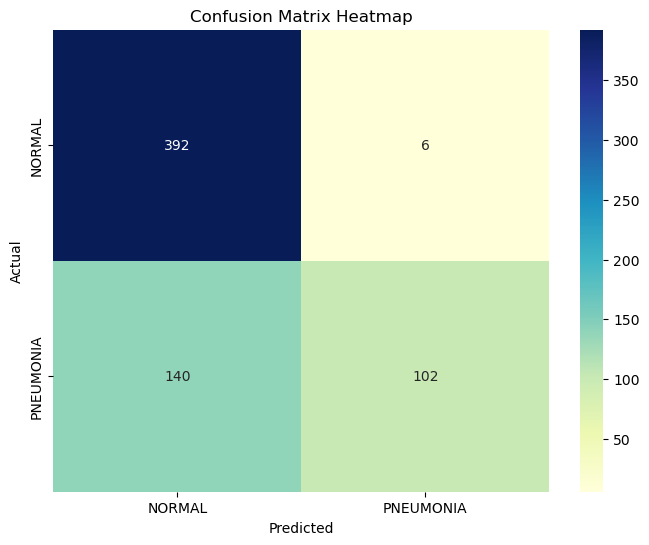

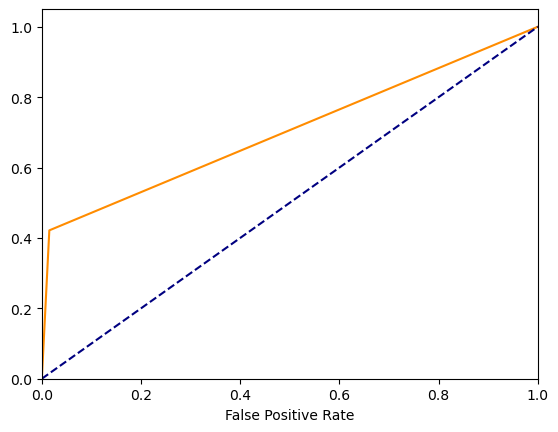

In [36]:
evaluateModel(m_lgb, X_test, y_test)

## Conclusion

Algorithms do not perform well on images, especially on new unknowns data. but there is a specialized deep learning algorithm that perform well on the image classification: it's the Convolutional Neural Network CNN for short. We use it in an another notebook: "tensorflow.ipynb"